In [3]:
from glob import glob
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models

data_dir = '/kaggle/input/tiny-object-detection/SkyFusion'

train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')

train_ds = sorted(glob(f'{train_dir}/*.jpg'))
valid_ds = sorted(glob(f'{valid_dir}/*.jpg'))
test_ds = sorted(glob(f'{test_dir}/*.jpg'))

print(len(train_ds), len(valid_ds), len(test_ds))

2094 449 449


In [4]:
!pip install pycocotools

## train 데이터 전처리

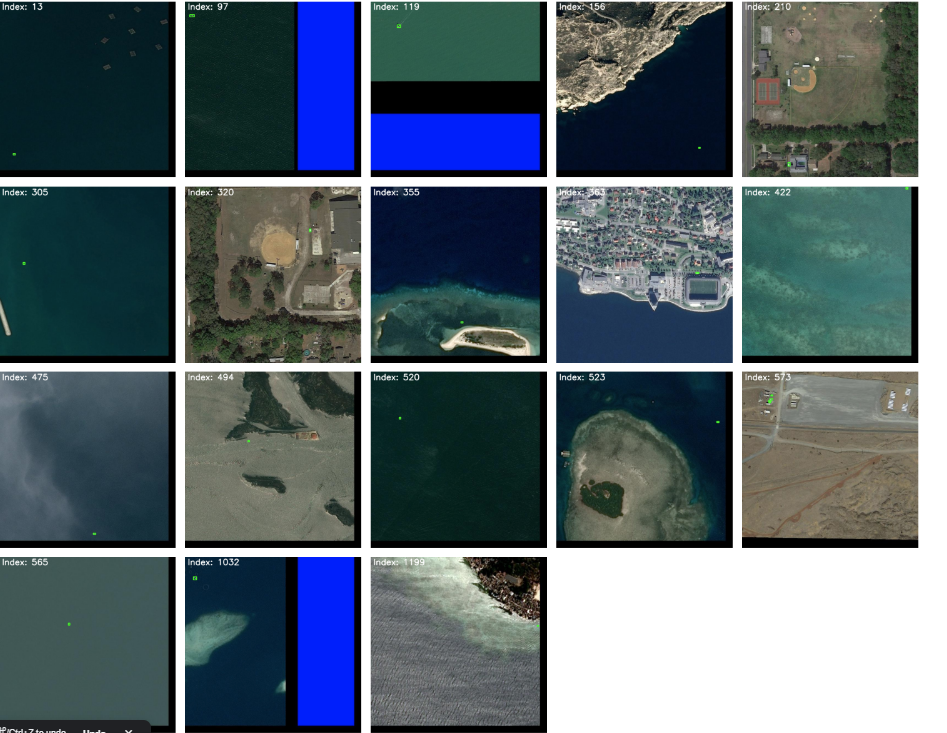

## train _df에서 해당인덱스에 해당하는 이미지 list 에서 전부 지우기.

selected_indices = [13, 97, 119, 156, 210, 305, 320, 355, 363, 422, 475, 494, 520, 523, 573, 565, 1032, 1199]

In [5]:
label_to_names = {'1' : 'Aircraft', '2' : 'ship', '3' : 'vehicle'}

In [6]:
import pandas as pd # data processing
from pycocotools.coco import COCO
import json # load json annotations

# Data Visulization libraries 
import matplotlib.pyplot as plt
import seaborn as sns 

SkyFusion_ann = open(r"/kaggle/input/tiny-object-detection/SkyFusion/train/_annotations.coco.json")
SkyFusion_COCO = json.load(SkyFusion_ann)

images = SkyFusion_COCO['images']

selected_indices = [13, 97, 119, 156, 210, 305, 320, 355, 363, 422, 475, 494, 520, 523, 573, 565, 1032, 1199]
train_image_name = []
train_data = []
for i in range(len(images)):
    if i not in selected_indices:
        train_image_name.append({images[i]['id'] : images[i]['file_name']})
        train_data.append(train_dir + '/' + images[i]['file_name'])
        
SkyFusion_train = pd.DataFrame(SkyFusion_COCO['annotations'])

SF = pd.DataFrame(SkyFusion_train['image_id'].unique(), columns=['image_id'])
a = SF.iloc[selected_indices]

file_names_to_remove = a['image_id'].tolist()

SkyFusion_train = SkyFusion_train[~SkyFusion_train['image_id'].isin(file_names_to_remove)]

SkyFusion_train.drop(columns=['id','area', 'segmentation','iscrowd'], axis=1, inplace=True)

# 딕셔너리를 하나로 합침
mapping = {k: v for d in train_image_name for k, v in d.items()}

# image_id를 기준으로 값을 매핑
SkyFusion_train['image_id'] = SkyFusion_train['image_id'].map(mapping)

SkyFusion_train

,image_id,category_id,bbox
0,P2491__1-0__1200___1764_png_jpg.rf.00342c6c14a...,3,"[259, 49, 4.8, 9.6]"
1,P2491__1-0__1200___1764_png_jpg.rf.00342c6c14a...,3,"[284, 630, 4.8, 8.8]"
2,P2491__1-0__1200___1764_png_jpg.rf.00342c6c14a...,3,"[281, 568, 4, 8.8]"
3,P2491__1-0__1200___1764_png_jpg.rf.00342c6c14a...,3,"[288, 570, 4.8, 10.4]"
4,P2491__1-0__1200___1764_png_jpg.rf.00342c6c14a...,3,"[303, 553, 4.8, 9.6]"
...,...,...,...
43570,P1875__1-0__600___600_png_jpg.rf.db3d3c9f59c7c...,3,"[470, 529, 5.6, 7.2]"
43571,P1875__1-0__600___600_png_jpg.rf.db3d3c9f59c7c...,3,"[442, 526, 8, 4.8]"
43572,P1875__1-0__600___600_png_jpg.rf.db3d3c9f59c7c...,3,"[587, 315, 5.6, 6.4]"
43573,P1875__1-0__600___600_png_jpg.rf.db3d3c9f59c7c...,3,"[602, 333, 7.2, 5.6]"


In [7]:
# valid-data 전처리

import pandas as pd # data processing
from pycocotools.coco import COCO
import json # load json annotations

# Data Visulization libraries 
import matplotlib.pyplot as plt
import seaborn as sns

SkyFusion_ann_valid = open(r"/kaggle/input/tiny-object-detection/SkyFusion/valid/_annotations.coco.json")
SkyFusion_COCO_valid = json.load(SkyFusion_ann_valid)

valid_images = SkyFusion_COCO_valid['images']
# print(images)
valid_image_name = []
valid_data = []
for i in range(len(valid_images)):
    valid_image_name.append({valid_images[i]['id'] : valid_images[i]['file_name']})
    valid_data.append(valid_dir + '/' + valid_images[i]['file_name'])
        
SkyFusion_valid = pd.DataFrame(SkyFusion_COCO_valid['annotations'])

SkyFusion_valid.drop(columns=['id','area', 'segmentation','iscrowd'], axis=1, inplace=True)

# 딕셔너리를 하나로 합침
valid_mapping = {k: v for d in valid_image_name for k, v in d.items()}

# image_id를 기준으로 값을 매핑
SkyFusion_valid['image_id'] = SkyFusion_valid['image_id'].map(valid_mapping)

SkyFusion_valid

,image_id,category_id,bbox
0,c98a544c-4206-4176-b480-35b8bdf5bb14_1060_1060...,1,"[256, 131, 33.5, 31]"
1,c98a544c-4206-4176-b480-35b8bdf5bb14_1060_1060...,1,"[261, 93, 38, 28]"
2,c98a544c-4206-4176-b480-35b8bdf5bb14_1060_1060...,1,"[275, 53, 39, 30.5]"
3,c98a544c-4206-4176-b480-35b8bdf5bb14_1060_1060...,1,"[300, 16, 38.5, 29]"
4,c98a544c-4206-4176-b480-35b8bdf5bb14_1060_1060...,1,"[185, 5, 32.5, 29.5]"
...,...,...,...
8382,P2421__1-0__0___1200_png_jpg.rf.ffcf6b00e9073a...,3,"[447, 214, 9.6, 6.4]"
8383,P2421__1-0__0___1200_png_jpg.rf.ffcf6b00e9073a...,3,"[391, 252, 5.6, 9.6]"
8384,P2421__1-0__0___1200_png_jpg.rf.ffcf6b00e9073a...,3,"[545, 166, 4.8, 10.4]"
8385,P2421__1-0__0___1200_png_jpg.rf.ffcf6b00e9073a...,3,"[502, 442, 6.4, 6.4]"


In [8]:
# test-data 전처리

import pandas as pd # data processing
from pycocotools.coco import COCO
import json # load json annotations

# Data Visulization libraries 
import matplotlib.pyplot as plt
import seaborn as sns

SkyFusion_ann_test = open(r"/kaggle/input/tiny-object-detection/SkyFusion/test/_annotations.coco.json")
SkyFusion_COCO_test = json.load(SkyFusion_ann_test)

test_images = SkyFusion_COCO_test['images']
# print(images)
test_image_name = []
test_data = []
for i in range(len(test_images)):
    test_image_name.append({test_images[i]['id'] : test_images[i]['file_name']})
    test_data.append(test_dir + '/' + test_images[i]['file_name'])
        
SkyFusion_test = pd.DataFrame(SkyFusion_COCO_test['annotations'])

SkyFusion_test.drop(columns=['id','area', 'segmentation','iscrowd'], axis=1, inplace=True)

# 딕셔너리를 하나로 합침
test_mapping = {k: v for d in test_image_name for k, v in d.items()}

# image_id를 기준으로 값을 매핑
SkyFusion_test['image_id'] = SkyFusion_test['image_id'].map(test_mapping)

SkyFusion_test

,image_id,category_id,bbox
0,3c027498a_png_jpg.rf.da3db5f98f9637aa4c5a2e010...,2,"[411, 566, 18.4, 10.4]"
1,3c027498a_png_jpg.rf.da3db5f98f9637aa4c5a2e010...,2,"[199, 546, 12, 8]"
2,3c027498a_png_jpg.rf.da3db5f98f9637aa4c5a2e010...,2,"[205, 532, 12.8, 5.6]"
3,3c027498a_png_jpg.rf.da3db5f98f9637aa4c5a2e010...,2,"[330, 554, 11.2, 16]"
4,3c027498a_png_jpg.rf.da3db5f98f9637aa4c5a2e010...,2,"[242, 566, 10.4, 6.4]"
...,...,...,...
11746,27cd32ba-c86a-419f-b544-601dd67c5d36_0_1060_jp...,1,"[0, 208, 34, 52]"
11747,0f7aba2e0_png_jpg.rf.d48df3a36a77714608eea333e...,2,"[396, 85, 8.8, 13.6]"
11748,0f7aba2e0_png_jpg.rf.d48df3a36a77714608eea333e...,2,"[384, 88, 8.8, 12]"
11749,0f7aba2e0_png_jpg.rf.d48df3a36a77714608eea333e...,2,"[389, 78, 7.2, 9.6]"


In [7]:
# import numpy as np
# from PIL import Image
# import matplotlib.pyplot as plt

# def add_gaussian_noise(image, mean=0, std=30):
#     """Add Gaussian noise to the image."""
#     image_np = np.array(image)
#     noise = np.random.normal(mean, std, image_np.shape)
#     noisy_image_np = np.clip(image_np + noise, 0, 255).astype(np.uint8)
#     return Image.fromarray(noisy_image_np)

# def add_salt_and_pepper_noise(image, amount=0.02):
#     """Add salt and pepper noise to the image."""
#     image_np = np.array(image)
#     num_salt = np.ceil(amount * image_np.size * 0.5)
#     num_pepper = np.ceil(amount * image_np.size * 0.5)
    
#     # Salt noise
#     salt_coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image_np.shape[:2]]
#     image_np[salt_coords[0], salt_coords[1], :] = 255

#     # Pepper noise
#     pepper_coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image_np.shape[:2]]
#     image_np[pepper_coords[0], pepper_coords[1], :] = 0

#     return Image.fromarray(image_np)

# def add_uniform_noise(image, low=0, high=80):
#     """Add uniform noise to the image."""
#     image_np = np.array(image)
#     noise = np.random.uniform(low, high, image_np.shape)
#     noisy_image_np = np.clip(image_np + noise, 0, 255).astype(np.uint8)
#     return Image.fromarray(noisy_image_np)

# def add_shakedrop_noise(image, drop_prob=0.1, shake_std=60):
#     """Add ShakeDrop noise to the image."""
#     image_np = np.array(image)
#     noise = np.random.normal(0, shake_std, image_np.shape)
    
#     # Decide which pixels will be dropped or shaken
#     drop_mask = np.random.rand(*image_np.shape[:2]) < drop_prob
#     shake_mask = ~drop_mask
    
#     # Apply noise where shaking is needed
#     image_np[shake_mask] = np.clip(image_np[shake_mask] + noise[shake_mask], 0, 255)
    
#     # Drop pixels (set to original image value, no noise added)
#     image_np[drop_mask] = image_np[drop_mask]
    
#     return Image.fromarray(image_np)


# # Load image
# image_path = '/kaggle/input/tiny-object-detection/SkyFusion/train/003b48a9e_png_jpg.rf.fea97d0443800bc662d17ff7c8db3bcc.jpg'
# original_image = Image.open(image_path).convert("RGB")

# # Apply noise
# gaussian_noisy_image = add_gaussian_noise(original_image)
# salt_and_pepper_noisy_image = add_salt_and_pepper_noise(original_image)
# uniform_noisy_image = add_uniform_noise(original_image)
# shakedrop_noisy_image = add_shakedrop_noise(original_image)

# # Display images in a 1x3 format
# fig, axs = plt.subplots(2, 2, figsize=(15,15))

# # Gaussian noise
# axs[0, 0].imshow(gaussian_noisy_image)
# axs[0, 0].set_title('Gaussian Noise')
# axs[0, 0].axis('off')

# # Salt and pepper noise
# axs[0, 1].imshow(salt_and_pepper_noisy_image)
# axs[0, 1].set_title('Salt & Pepper Noise')
# axs[0, 1].axis('off')

# # Uniform noise
# axs[1, 0].imshow(uniform_noisy_image)
# axs[1, 0].set_title('Uniform Noise')
# axs[1, 0].axis('off')

# # ShakeDrop noise
# axs[1, 1].imshow(shakedrop_noisy_image)
# axs[1, 1].set_title('ShakeDrop Noise')
# axs[1, 1].axis('off')

# # Show the plot
# plt.tight_layout()
# plt.show()

In [9]:
import pandas as pd
import glob

# Load your DataFrame (assuming it's named SkyFusion_train)
# SkyFusion_train = pd.read_csv("your_file.csv")  # Load your CSV if needed

# Initialize lists
image_list = []
bbox_list = []
category_list = []

# Get sorted image paths (make sure to adjust the pattern as necessary)
image_paths = sorted(glob.glob("/kaggle/input/tiny-object-detection/SkyFusion/train/*"))

# Create a dictionary to hold bounding boxes and category_ids for each image_id
bbox_dict = {}
for index, row in SkyFusion_train.iterrows():
    image_id = row['image_id']
    bbox = row['bbox']  # This should be a list of coordinates
    category_id = row['category_id']
    
    # Initialize the entry in the dictionary if it doesn't exist
    if image_id not in bbox_dict:
        bbox_dict[image_id] = {'bbox': [], 'category_id': []}
    
    # Append the bounding box and category to the lists for this image_id
    bbox_dict[image_id]['bbox'].append(bbox)
    bbox_dict[image_id]['category_id'].append(category_id)

# Loop through the sorted image paths
for img_path in image_paths:
    # Extract the image ID from the path (assuming the format is consistent)
    image_id = img_path.split('/')[-1]  # Adjust based on your file naming

    # Append to the lists
    if image_id in bbox_dict:
        image_list.append(img_path)
        bbox_list.append(bbox_dict[image_id]['bbox'])  # List of bounding boxes
        category_list.append(bbox_dict[image_id]['category_id'])  # List of category IDs

# Now image_list, bbox_list, and category_list are populated accordingly
print("Image List:", image_list[1:2])
print("Bounding Boxes List:", bbox_list[1:2])
print("Category List:", category_list[1:2])

Image List: ['/kaggle/input/tiny-object-detection/SkyFusion/train/014de911-7810-4f7d-8967-3e5402209f4a_0_0_jpg.rf.77e233628eec19d0fa0cc4a57a977fce.jpg']
Bounding Boxes List: [[[374, 10, 35, 35], [270, 54, 34, 44], [149, 26, 72, 75], [0, 0, 16, 39], [24, 186, 58, 65], [0, 120, 34, 50], [49, 517, 24, 34], [108, 511, 32, 40], [171, 512, 19, 33], [202, 455, 35, 45], [293, 278, 31, 36]]]
Category List: [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


In [10]:
import pandas as pd
import glob

# Load your test DataFrame (assuming it's named SkyFusion_test)
# SkyFusion_test = pd.read_csv("your_test_file.csv")  # Uncomment and replace with actual test CSV file path

# Initialize lists
valid_image_list = []
valid_bbox_list = []
valid_category_list = []

# Get sorted image paths (make sure to adjust the pattern as necessary)
valid_image_paths = sorted(glob.glob("/kaggle/input/tiny-object-detection/SkyFusion/valid/*"))  # Adjust the path for test images

# Create a dictionary to hold bounding boxes and category_ids for each image_id
valid_bbox_dict = {}
for index, row in SkyFusion_valid.iterrows():
    valid_image_id = row['image_id']
    valid_bbox = row['bbox']  # This should be a list of coordinates
    valid_category_id = row['category_id']
    
    # Initialize the entry in the dictionary if it doesn't exist
    if valid_image_id not in valid_bbox_dict:
        valid_bbox_dict[valid_image_id] = {'bbox': [], 'category_id': []}
    
    # Append the bounding box and category to the lists for this image_id
    valid_bbox_dict[valid_image_id]['bbox'].append(valid_bbox)
    valid_bbox_dict[valid_image_id]['category_id'].append(valid_category_id)

# Loop through the sorted image paths
for valid_img_path in valid_image_paths:
    # Extract the image ID from the path (assuming the format is consistent)
    valid_image_id = valid_img_path.split('/')[-1]  # Adjust based on your file naming

    # Append to the lists
    if valid_image_id in valid_bbox_dict:
        valid_image_list.append(valid_img_path)
        valid_bbox_list.append(valid_bbox_dict[valid_image_id]['bbox'])  # List of bounding boxes
        valid_category_list.append(valid_bbox_dict[valid_image_id]['category_id'])  # List of category IDs

# Now test_image_list, test_bbox_list, and test_category_list are populated accordingly
print("valid Image List:", valid_image_list[1:2])  # Print a sample
print("valid Bounding Boxes List:", valid_bbox_list[1:2])  # Print a sample
print("valid Category List:", valid_category_list[1:2])  # Print a sample

valid Image List: ['/kaggle/input/tiny-object-detection/SkyFusion/valid/01b04ce8d_png_jpg.rf.115536a4983063d08a7dfd8e0061567d.jpg']
valid Bounding Boxes List: [[[362, 408, 21.6, 26.4], [365, 433, 7.2, 11.2]]]
valid Category List: [[2, 2]]


In [11]:
import pandas as pd
import glob

# Load your test DataFrame (assuming it's named SkyFusion_test)
# SkyFusion_test = pd.read_csv("your_test_file.csv")  # Uncomment and replace with actual test CSV file path

# Initialize lists
test_image_list = []
test_bbox_list = []
test_category_list = []

# Get sorted image paths (make sure to adjust the pattern as necessary)
test_image_paths = sorted(glob.glob("/kaggle/input/tiny-object-detection/SkyFusion/test/*"))  # Adjust the path for test images

# Create a dictionary to hold bounding boxes and category_ids for each image_id
test_bbox_dict = {}
for index, row in SkyFusion_test.iterrows():
    test_image_id = row['image_id']
    test_bbox = row['bbox']  # This should be a list of coordinates
    test_category_id = row['category_id']
    
    # Initialize the entry in the dictionary if it doesn't exist
    if test_image_id not in test_bbox_dict:
        test_bbox_dict[test_image_id] = {'bbox': [], 'category_id': []}
    
    # Append the bounding box and category to the lists for this image_id
    test_bbox_dict[test_image_id]['bbox'].append(test_bbox)
    test_bbox_dict[test_image_id]['category_id'].append(test_category_id)

# Loop through the sorted image paths
for test_img_path in test_image_paths:
    # Extract the image ID from the path (assuming the format is consistent)
    test_image_id = test_img_path.split('/')[-1]  # Adjust based on your file naming

    # Append to the lists
    if test_image_id in test_bbox_dict:
        test_image_list.append(test_img_path)
        test_bbox_list.append(test_bbox_dict[test_image_id]['bbox'])  # List of bounding boxes
        test_category_list.append(test_bbox_dict[test_image_id]['category_id'])  # List of category IDs

# Now test_image_list, test_bbox_list, and test_category_list are populated accordingly
print("Test Image List:", test_image_list[1:2])  # Print a sample
print("Test Bounding Boxes List:", test_bbox_list[1:2])  # Print a sample
print("Test Category List:", test_category_list[1:2])  # Print a sample

Test Image List: ['/kaggle/input/tiny-object-detection/SkyFusion/test/014de911-7810-4f7d-8967-3e5402209f4a_0_0_jpg.rf.7b6e48f643ecb69e2a57f0dc685686ce.jpg']
Test Bounding Boxes List: [[[595, 231, 35, 35], [543, 336, 44, 34], [540, 419, 75, 72.5], [601, 624, 39, 16], [389, 558, 65, 57.5], [470, 606, 50, 34], [90, 567, 33.5, 24.5], [90, 500, 39.5, 32], [96, 450, 33, 19], [140, 403, 45, 35], [326, 316, 36.5, 31]]]
Test Category List: [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


In [12]:
print(len(image_list),len(bbox_list),len(category_list))

2076 2076 2076


In [13]:
print(len(valid_image_list),len(valid_bbox_list),len(valid_category_list))

449 449 449


In [14]:
train_image_list = image_list + valid_image_list
train_bbox_list = bbox_list + valid_bbox_list
train_category_list = category_list + valid_category_list

In [15]:
print(len(train_image_list),len(train_bbox_list),len(train_category_list))

2525 2525 2525


In [16]:
print(len(test_image_list),len(test_bbox_list),len(test_category_list))

449 449 449


In [17]:
new_train_bbox_list = []

# Iterate through the original bbox_list
for bbox_group in train_bbox_list:  # Each bbox_group contains bounding boxes
    temp_group = []  # Temporary group to store converted boxes
    for bbox in bbox_group:  # Each bbox is [x, y, w, h]
        x, y, w, h = bbox
        # Convert to [x1, y1, x2, y2]
        temp = [x, y, x + w, y + h]  
        temp_group.append(temp)  # Add to the temp group
    new_train_bbox_list.append(temp_group)  # Append the temp group to new_bbox_list

# Now, new_bbox_list contains the modified structure
print(len(train_image_list), len(new_train_bbox_list), len(train_category_list))

2525 2525 2525


In [18]:
new_test_bbox_list = []

# Iterate through the original bbox_list
for bbox_group in test_bbox_list:  # Each bbox_group contains bounding boxes
    temp_group = []  # Temporary group to store converted boxes
    for bbox in bbox_group:  # Each bbox is [x, y, w, h]
        x, y, w, h = bbox
        # Convert to [x1, y1, x2, y2]
        temp = [x, y, x + w, y + h]  
        temp_group.append(temp)  # Add to the temp group
    new_test_bbox_list.append(temp_group)  # Append the temp group to new_bbox_list

# Now, new_bbox_list contains the modified structure
print(len(test_image_list), len(new_test_bbox_list), len(test_category_list))

449 449 449


In [19]:
import os
import random
import numpy as np
from PIL import Image
import shutil

# Noisy image functions

def add_gaussian_noise(image, mean=0, std=30):
    image_np = np.array(image)
    noise = np.random.normal(mean, std, image_np.shape)
    noisy_image_np = np.clip(image_np + noise, 0, 255).astype(np.uint8)
    return Image.fromarray(noisy_image_np)

def add_salt_and_pepper_noise(image, amount=0.02):
    image_np = np.array(image)
    num_salt = np.ceil(amount * image_np.size * 0.5)
    num_pepper = np.ceil(amount * image_np.size * 0.5)

    # Salt noise
    salt_coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image_np.shape[:2]]
    image_np[salt_coords[0], salt_coords[1], :] = 255

    # Pepper noise
    pepper_coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image_np.shape[:2]]
    image_np[pepper_coords[0], pepper_coords[1], :] = 0

    return Image.fromarray(image_np)

def add_uniform_noise(image, low=0, high=80):
    image_np = np.array(image)
    noise = np.random.uniform(low, high, image_np.shape)
    noisy_image_np = np.clip(image_np + noise, 0, 255).astype(np.uint8)
    return Image.fromarray(noisy_image_np)

def add_shakedrop_noise(image, drop_prob=0.1, shake_std=60):
    image_np = np.array(image)
    noise = np.random.normal(0, shake_std, image_np.shape)

    # Drop mask
    drop_mask = np.random.rand(*image_np.shape[:2]) < drop_prob
    shake_mask = ~drop_mask

    # Apply noise where shaking is needed
    image_np[shake_mask] = np.clip(image_np[shake_mask] + noise[shake_mask], 0, 255)

    return Image.fromarray(image_np)

# Apply random noise function
def apply_random_noise(image):
    noise_functions = [add_gaussian_noise, add_salt_and_pepper_noise, add_uniform_noise, add_shakedrop_noise]
    selected_noise = random.choice(noise_functions)
    return selected_noise(image)

# YOLO format conversion function
def convert_bbox_to_yolo(bbox, img_width, img_height):
    x_min, y_min, x_max, y_max = bbox
    x_center = (x_min + x_max) / 2 / img_width
    y_center = (y_min + y_max) / 2 / img_height
    width = (x_max - x_min) / img_width
    height = (y_max - y_min) / img_height
    return [x_center, y_center, width, height]

def save_yolo_labels(bboxes, categories, img_name, img_width, img_height, label_dir):
    label_file_path = os.path.join(label_dir, f"{img_name}.txt")
    with open(label_file_path, 'w') as f:
        for bbox, category in zip(bboxes, categories):
            # Convert bounding boxes to YOLO format
            yolo_bbox = convert_bbox_to_yolo(bbox, img_width, img_height)
            # YOLO format: class x_center y_center width height
            bbox_str = " ".join([str(x) for x in yolo_bbox])
            f.write(f"{category - 1} {bbox_str}\n")

def save_yolo_format(image_list, bbox_list, category_list, img_dir, label_dir):
    for img_path, bboxes, categories in zip(image_list, bbox_list, category_list):
        img_file = os.path.basename(img_path)
        img_name = os.path.splitext(img_file)[0]

        # Save original image
        dst_path = os.path.join(img_dir, img_file)
        if not os.path.exists(dst_path):
            shutil.copy2(img_path, dst_path)

        # Get image size
        img = Image.open(img_path)
        img_width, img_height = img.size

        # Save YOLO labels for original image
        save_yolo_labels(bboxes, categories, img_name, img_width, img_height, label_dir)

        # Create a noisy version
        noisy_image = apply_random_noise(img)

        # Generate a unique noisy image filename
        noisy_img_file = f"{img_name}_noisy_{np.random.randint(1000)}.jpg"
        noisy_img_path = os.path.join(img_dir, noisy_img_file)

        # Save noisy image if it doesn't exist
        if not os.path.exists(noisy_img_path):
            noisy_image.save(noisy_img_path)

            # Save YOLO labels for noisy image
            save_yolo_labels(bboxes, categories, os.path.splitext(noisy_img_file)[0], img_width, img_height, label_dir)

# Define your dataset paths
train_img_dir = '/kaggle/working/train/images'
train_label_dir = '/kaggle/working/train/labels'
test_img_dir = '/kaggle/working/test/images'
test_label_dir = '/kaggle/working/test/labels'

# Create directories
os.makedirs(train_img_dir, exist_ok=True)
os.makedirs(train_label_dir, exist_ok=True)
os.makedirs(test_img_dir, exist_ok=True)
os.makedirs(test_label_dir, exist_ok=True)

# Prepare train data
save_yolo_format(train_image_list, new_train_bbox_list, train_category_list, train_img_dir, train_label_dir)

# Prepare test/validation data
save_yolo_format(test_image_list, new_test_bbox_list, test_category_list, test_img_dir, test_label_dir)

print("Dataset preparation complete.")

Dataset preparation complete.


In [20]:
# Clone the YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5
%cd yolov5

# Install the required packages
!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 16965, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 16965 (delta 82), reused 100 (delta 49), pack-reused 16805 (from 1)
Receiving objects: 100% (16965/16965), 15.71 MiB | 31.67 MiB/s, done.
Resolving deltas: 100% (11615/11615), done.
/kaggle/working/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 42.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.1/875.1 kB 44.3 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.5.0
    Uninstalling Pillow-9.5.0:
      Successfully uninstalled Pillow-9.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pointpats 2.5.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.1 requires shapel

In [21]:
# data.yaml

train: '/kaggle/working/train/images'  # Path to train images
val: '/kaggle/working/test/images'    # Path to validation images

nc: 3  # Number of classes (your dataset has 3 classes: 'Aircraft', 'Ship', 'Vehicle')

names: ['Aircraft', 'Ship', 'Vehicle']  # List of class names

In [22]:
data_yaml = """
train: /kaggle/working/train/images 
val: /kaggle/working/test/images

nc: 3 
names: ['Aircraft', 'Ship', 'Vehicle']
"""

# Save the content into a data.yaml file
with open('/kaggle/working/data.yaml', 'w') as file:
    file.write(data_yaml)

print("data.yaml file created successfully!")

data.yaml file created successfully!


In [27]:
# Run YOLOv5 training with the custom dataset
!python train.py --img 640 --batch 16 --epochs 50 --data /kaggle/working/data.yaml --weights yolov5s.pt --cache

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5s.pt, cfg=, data=/kaggle/working/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias

---

## 양자화

In [52]:
# 양자화 전 모델 평가
!python /kaggle/working/yolov5/val.py --weights /kaggle/working/yolov5/runs/train/exp2/weights/best.pt --data /kaggle/working/data.yaml --img 640

val: data=/kaggle/working/data.yaml, weights=['/kaggle/working/yolov5/runs/train/exp2/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-368-gb163ff8d Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)

Fusing layers... 
Model summary: 157 layers, 1763224 parameters, 0 gradients, 4.1 GFLOPs
val: Scanning /kaggle/working/test/labels.cache... 898 images, 0 backgrounds, 0 
                 Class     Images  Instances          P          R      mAP50   
                   all        898      23502      0.643      0.493      0.496      0.272
              Aircraft        898       3936      0.914      0.913      0.926      0.637
                  Ship        898        812      0.508      0.324      0.305     0.0

In [56]:
from ultralytics import YOLO
import torch

# 학습된 모델 로드
model = YOLO('/kaggle/working/yolov5/runs/train/exp2/weights/best.pt')

# Layer Fusion
def fuse_yolo_layers(model):
    for module_name, module in model.model.named_children():
        if isinstance(module, torch.nn.Sequential):
            for i, layer in enumerate(module):
                if isinstance(layer, torch.nn.Conv2d):
                    # Conv + BatchNorm + ReLU 레이어를 결합
                    torch.quantization.fuse_modules(module, [str(i), str(i+1), str(i+2)], inplace=True)
    return model

fuse_yolo_layers(model.model)

# 양자화 설정
model.model.eval()
model.model.qconfig = torch.quantization.get_default_qconfig('fbgemm')

# 양자화 준비
torch.quantization.prepare(model.model, inplace=True)

# 완전한 양자화 수행 (이 단계가 실제 양자화 변환을 수행합니다)
quantized_model = torch.quantization.convert(model.model, inplace=True)

# 모델 체크포인트 형식으로 저장
ckpt = {
    'model': quantized_model,  # 양자화된 모델을 저장
    'optimizer': None,
    'epoch': -1,
    'updates': None,
    'train_args': None,
    'date': None
}

torch.save(ckpt, '/kaggle/working/yolov5/runs/train/exp2/weights/quantized_model.pt')

In [58]:
# 양자화 후 모델 평가
!python /kaggle/working/yolov5/val.py --weights /kaggle/working/yolov5/runs/train/exp2/weights/quantized_model.pt --data /kaggle/working/data.yaml --img 640

val: data=/kaggle/working/data.yaml, weights=['/kaggle/working/yolov5/runs/train/exp2/weights/quantized_model.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-368-gb163ff8d Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)

Traceback (most recent call last):
  File "/kaggle/working/yolov5/val.py", line 604, in <module>
    main(opt)
  File "/kaggle/working/yolov5/val.py", line 575, in main
    run(**vars(opt))
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/_contextlib.py", line 116, in decorate_context
    return func(*args, **kwargs)
  File "/kaggle/working/yolov5/val.py", line 270, in run
    model = DetectMultiBackend(weights, device=device, dnn=dnn, data=data, fp16=half)
  File "/kaggle/working/yolov5